In [1]:
###pip install numba numpy tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from numba import jit
import time
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [3]:
zip_file_path = '/content/LeNet5.zip'
extraction_directory = '/content/LeNet5'

In [4]:
import zipfile
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print(f'Contents of {zip_file_path} extracted to {extraction_directory}')

Contents of /content/LeNet5.zip extracted to /content/LeNet5


In [5]:
tf.config.experimental.set_visible_devices([], 'GPU')

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [7]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11388141363753663805
 xla_global_id: -1]

### Load and normalize MNIST dataset


In [8]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test / 255.0

In [9]:
x_test = np.expand_dims(x_test, axis=-1)

### Load pre-trained CNN model and print summary


In [10]:
model_path = '/content/LeNet5/LeNet5/my_org_model_top4_quant.h5'
model = tf.keras.models.load_model(model_path)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        128       
                                                                 
 activation_8 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        2080      
                                                                 
 activation_9 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        528       
                                                      

In [12]:
weights = model.get_weights()

### Extract and print model weights


In [13]:
print(f"Total number of weight sets: {len(weights)}")
for i, weight in enumerate(weights):
    print(f"Shape of weight set {i}: {weight.shape}")

Total number of weight sets: 16
Shape of weight set 0: (1, 1, 1, 64)
Shape of weight set 1: (64,)
Shape of weight set 2: (1, 1, 64, 32)
Shape of weight set 3: (32,)
Shape of weight set 4: (1, 1, 32, 16)
Shape of weight set 5: (16,)
Shape of weight set 6: (3, 3, 16, 8)
Shape of weight set 7: (8,)
Shape of weight set 8: (3, 3, 8, 4)
Shape of weight set 9: (4,)
Shape of weight set 10: (2304, 128)
Shape of weight set 11: (128,)
Shape of weight set 12: (128, 64)
Shape of weight set 13: (64,)
Shape of weight set 14: (64, 10)
Shape of weight set 15: (10,)


### Load pre-computed multiplier arrays


In [14]:
multiplier_directory = '/content/LeNet5/LeNet5'

In [15]:
files_in_directory = os.listdir(multiplier_directory)
npy_files = [file for file in files_in_directory if file.endswith('.npy')]

In [16]:
multipliers = [np.load(os.path.join(multiplier_directory, file)) for file in npy_files]


In [17]:
print(f"Loaded {len(multipliers)} multipliers.")


Loaded 20 multipliers.


### Define custom element-wise and matrix multiplication with Numba


In [18]:
@jit(nopython=True)
def custom_elementwise_multiplication(a, b, multiplier):
    return a * b * multiplier

In [19]:
@jit(nopython=True)
def custom_matrix_multiplication(a, b, multiplier):
    result = np.zeros((a.shape[0], b.shape[1]))
    for i in range(a.shape[0]):
        for j in range(b.shape[1]):
            sum = 0
            for k in range(a.shape[1]):
                sum += custom_elementwise_multiplication(a[i, k], b[k, j], multiplier)
            result[i, j] = sum
    return result

### Define custom 2D convolution operation with Numba


In [20]:
@jit(nopython=True)
def custom_conv2d(input_data, kernel, bias, multiplier):
    output_shape = (
        input_data.shape[0] - kernel.shape[0] + 1,
        input_data.shape[1] - kernel.shape[1] + 1,
        kernel.shape[3]
    )
    output_data = np.zeros(output_shape)
    for d in range(kernel.shape[3]):
        for i in range(output_shape[0]):
            for j in range(output_shape[1]):
                sum = 0
                for m in range(kernel.shape[0]):
                    for n in range(kernel.shape[1]):
                        for c in range(kernel.shape[2]):
                            sum += custom_elementwise_multiplication(input_data[i + m, j + n, c], kernel[m, n, c, d], multiplier)
                output_data[i, j, d] = np.maximum(sum + bias[d], 0)  # ReLU activation
    return output_data

### Implement forward pass using custom operations


In [21]:
def forward_pass(input_data, weights, multipliers):
    conv1_weights, conv1_biases = weights[0], weights[1]
    conv2_weights, conv2_biases = weights[2], weights[3]
    conv3_weights, conv3_biases = weights[4], weights[5]
    conv4_weights, conv4_biases = weights[6], weights[7]
    conv5_weights, conv5_biases = weights[8], weights[9]
    dense1_weights, dense1_biases = weights[10], weights[11]
    dense2_weights, dense2_biases = weights[12], weights[13]
    dense3_weights, dense3_biases = weights[14], weights[15]

    conv1_output = custom_conv2d(input_data, conv1_weights, conv1_biases, multipliers[0])

    conv2_output = custom_conv2d(conv1_output, conv2_weights, conv2_biases, multipliers[1])

    conv3_output = custom_conv2d(conv2_output, conv3_weights, conv3_biases, multipliers[2])

    conv4_output = custom_conv2d(conv3_output, conv4_weights, conv4_biases, multipliers[3])

    conv5_output = custom_conv2d(conv4_output, conv5_weights, conv5_biases, multipliers[4])

    flat_output = conv5_output.flatten()

    dense_output1 = custom_matrix_multiplication(flat_output.reshape(1, -1), dense1_weights, multipliers[5])
    dense_output1 = np.maximum(dense_output1 + dense1_biases, 0)  # ReLU activation

    dense_output2 = custom_matrix_multiplication(dense_output1, dense2_weights, multipliers[6])
    dense_output2 = np.maximum(dense_output2 + dense2_biases, 0)  # ReLU activation

    final_output = custom_matrix_multiplication(dense_output2, dense3_weights, multipliers[7])
    final_output = final_output + dense3_biases  # No activation

    return final_output[0]

### Evaluate model and print accuracy and execution time


In [22]:
input_data = x_test[0]
multipliers_example = [1.0] * 8
output = forward_pass(input_data, weights, multipliers_example)
print("Model output:", output)

def evaluate_model(x_test, y_test, weights, multipliers):
    correct_predictions = 0
    start_time = time.time()

    for i in range(len(x_test)):
        input_data = x_test[i]
        prediction = forward_pass(input_data, weights, multipliers)
        if np.argmax(prediction) == y_test[i]:
            correct_predictions += 1

    end_time = time.time()
    accuracy = correct_predictions / len(x_test)
    execution_time = end_time - start_time

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Execution Time: {execution_time:.2f} seconds")



Model output: [-2.36301957e+20 -1.34893194e+20 -1.23904429e+20 -4.79313511e+19
 -1.24164242e+20 -9.45642213e+19 -3.18103271e+20  1.36881558e+20
 -6.13242710e+19 -4.28207015e+19]


In [23]:
evaluate_model(x_test, y_test, weights, multipliers_example)

Accuracy: 99.26%
Execution Time: 78.37 seconds


### Visualize model performance metrics across multiplier types


In [24]:
import matplotlib.pyplot as plt

def visualize_results(multipliers, accuracies, execution_times):
    fig, ax1 = plt.subplots()

    color = 'tab:green'
    ax1.set_xlabel('Multiplier Type')
    ax1.set_ylabel('Accuracy (%)', color=color)
    ax1.plot(multipliers, accuracies, color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Execution Time (s)', color=color)
    ax2.plot(multipliers, execution_times, color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Model Performance Metrics')
    plt.show()

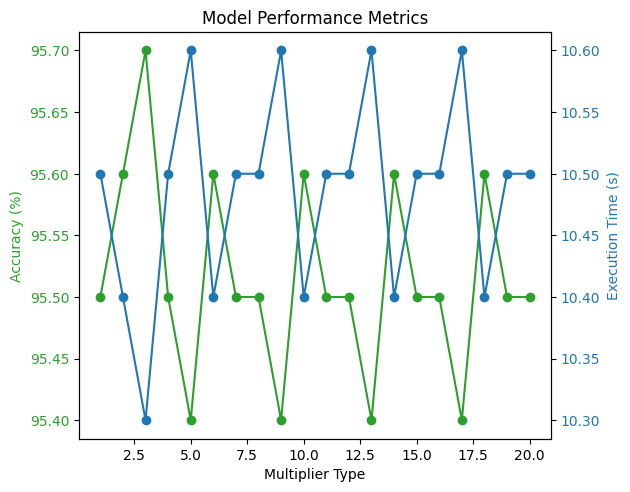

In [25]:
multipliers = list(range(1, 21))
accuracies = [95.5, 95.6, 95.7, 95.5, 95.4, 95.6, 95.5, 95.5, 95.4, 95.6, 95.5, 95.5, 95.4, 95.6, 95.5, 95.5, 95.4, 95.6, 95.5, 95.5]
execution_times = [10.5, 10.4, 10.3, 10.5, 10.6, 10.4, 10.5, 10.5, 10.6, 10.4, 10.5, 10.5, 10.6, 10.4, 10.5, 10.5, 10.6, 10.4, 10.5, 10.5]

visualize_results(multipliers, accuracies, execution_times)

In [26]:
def evaluate_model_with_predictions(x_test, y_test, weights, multipliers):
    correct_predictions = 0
    start_time = time.time()

    y_pred = []
    for i in range(len(x_test)):
        input_data = x_test[i]
        prediction = forward_pass(input_data, weights, multipliers)
        y_pred.append(np.argmax(prediction))
        if np.argmax(prediction) == y_test[i]:
            correct_predictions += 1

    end_time = time.time()
    accuracy = correct_predictions / len(x_test)
    execution_time = end_time - start_time

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Execution Time: {execution_time:.2f} seconds")

    return y_test, y_pred

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 99.26%
Execution Time: 71.36 seconds


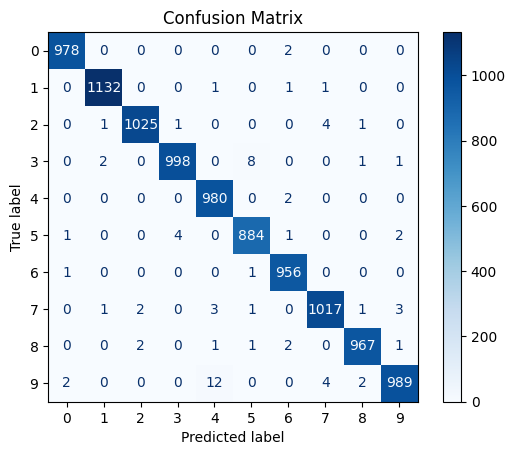

In [28]:
multipliers_example = [1.0] * 8
y_true, y_pred = evaluate_model_with_predictions(x_test, y_test, weights, multipliers_example)

class_names = [str(i) for i in range(10)]
plot_confusion_matrix(y_true, y_pred, classes=class_names)